# GAN para generar prendas de ropa

In [ ]:
# Importa las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

# Cargamos el dateset

In [ ]:
# Cargar dataset
fashion_mnist = keras.datasets.fashion_mnist

Creamos los datos de entrenamiento y sus labels para así mostrar el nombre de la prenda a la hora de enseñar una imágen

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Etiquetas de las clases de Fashion MNIST
class_names = ['Camiseta/Top', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla deportiva', 'Bolso', 'Botín']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Mostramos 5 prendas aleatorias

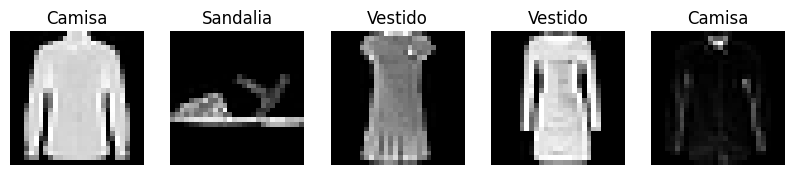

In [ ]:
# Seleccionar 5 imágenes aleatorias
indices = np.random.choice(len(train_images), 5, replace=False)
sample_images = train_images[indices]
sample_labels = train_labels[indices]

# Graficar las imágenes
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i], cmap="gray")
    plt.title(class_names[sample_labels[i]])
    plt.axis("off")

plt.show()

Normalizamos las imágenes y creamos el dataset de entrenamiento

In [ ]:
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

BATCH_SIZE = 256
BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Verifica la estructura del dataset
for batch in train_dataset.take(1): # Toma un lote
  print("Dimensiones del lote:", batch.shape)
  print("Rango: de", batch.numpy().min(), "a", batch.numpy().max())

Dimensiones del lote: (256, 28, 28, 1)
Rango: de -1.0 a 1.0


In [ ]:
# Define el generador
LATENT_DIM = 100

generator = keras.Sequential([
    # Capa densa inicial
    layers.Dense(7 * 7 * 256, input_shape=(LATENT_DIM,)), # Probar con use_bias=False
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Redimensión a las dimensiones iniciales
    layers.Reshape((7, 7, 256)),

    # Primera capa de convolución
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2D(1, (3, 3), activation="tanh") # Probar con use_bias=False
])

generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,342,465 (8.94 MB)

 Trainable params: 2,316,993 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

Dimensiones de cada capa

In [ ]:
noise = tf.random.normal([1, LATENT_DIM])
x = noise
for layer in generator.layers:
  x = layer(x)
  print(f"{layer.name}: {x.shape}")

dense: (1, 12544)
batch_normalization: (1, 12544)
leaky_re_lu: (1, 12544)
reshape: (1, 7, 7, 256)
conv2d_transpose: (1, 14, 14, 128)
batch_normalization_1: (1, 14, 14, 128)
leaky_re_lu_1: (1, 14, 14, 128)
conv2d_transpose_1: (1, 28, 28, 64)
batch_normalization_2: (1, 28, 28, 64)
leaky_re_lu_2: (1, 28, 28, 64)
conv2d: (1, 26, 26, 1)


In [ ]:
generated_image = generator(noise, training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)

Dimensiones de la imagen generada: (1, 26, 26, 1)


Dimensiones de la imagen generada: (1, 26, 26, 1)
Rango de valores de la imagen generada: de -0.056172844 a 0.09387669


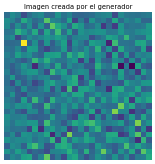

In [ ]:
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la imagen generada
print("Dimensiones de la imagen generada:", generated_image.shape)

# Verifica el rango de valores de la imagen generada
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())

# Muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2) # Reescala la imagen al rango [0, 1] para visualizarla
plt.axis("off")
plt.title("Imagen creada por el generador")
plt.show()

Creación del discriminador

In [ ]:
# Define el discriminador
discriminator = keras.Sequential([
    # Primera capa convolucional
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Aplana la salida
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid") # Decide si la imagen es real o generada
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prueba el discriminador con una imagen creada por el generador
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Pasa la imagen por el discriminador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):", decision.numpy())

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): [[0.5002357]]


Por ahora todo va perfecto ya que el discriminador indica incertidumbre ya que no entrenamos aún la GAN

# Entrenamiento

In [ ]:
EPOCHS = 10
# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)  # No se necesita logits porque la última capa era una sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

Época 1/10
Pérdida del discriminador: 1.3599351644515991, Pérdida del generador: 0.7246392965316772
Pérdida del discriminador: 1.356128454208374, Pérdida del generador: 0.6816721558570862
Pérdida del discriminador: 1.3524580001831055, Pérdida del generador: 0.6565693616867065
Pérdida del discriminador: 1.3313028812408447, Pérdida del generador: 0.6443837285041809
Pérdida del discriminador: 1.3098132610321045, Pérdida del generador: 0.650606632232666
Pérdida del discriminador: 1.2699097394943237, Pérdida del generador: 0.6616470217704773
Pérdida del discriminador: 1.2301353216171265, Pérdida del generador: 0.6730396747589111
Pérdida del discriminador: 1.1997971534729004, Pérdida del generador: 0.6846984028816223
Pérdida del discriminador: 1.1592612266540527, Pérdida del generador: 0.6947115063667297
Pérdida del discriminador: 1.136031150817871, Pérdida del generador: 0.7019006013870239
Pérdida del discriminador: 1.1244471073150635, Pérdida del generador: 0.7040811777114868
Pérdida del d

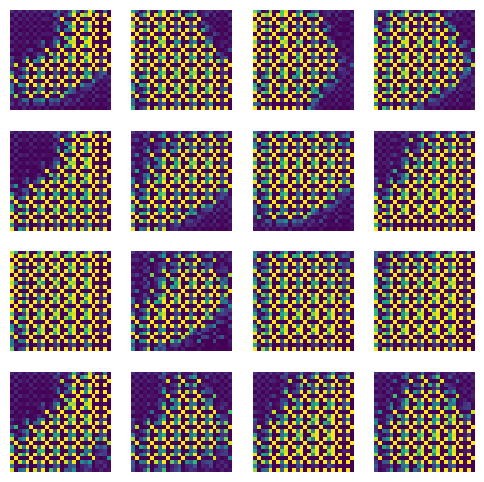

Época 3/10
Pérdida del discriminador: 0.0066275205463171005, Pérdida del generador: 5.754138946533203
Pérdida del discriminador: 0.006953762378543615, Pérdida del generador: 5.774500846862793
Pérdida del discriminador: 0.006217197515070438, Pérdida del generador: 5.79284143447876
Pérdida del discriminador: 0.006591744255274534, Pérdida del generador: 5.807917594909668
Pérdida del discriminador: 0.009038752876222134, Pérdida del generador: 5.852806091308594
Pérdida del discriminador: 0.007546892389655113, Pérdida del generador: 5.864051342010498
Pérdida del discriminador: 0.005428651347756386, Pérdida del generador: 5.864885330200195
Pérdida del discriminador: 0.005768103990703821, Pérdida del generador: 5.882966041564941
Pérdida del discriminador: 0.004995962139219046, Pérdida del generador: 5.922589302062988
Pérdida del discriminador: 0.004839029628783464, Pérdida del generador: 5.929205894470215
Pérdida del discriminador: 0.0049691637977957726, Pérdida del generador: 5.93982696533203

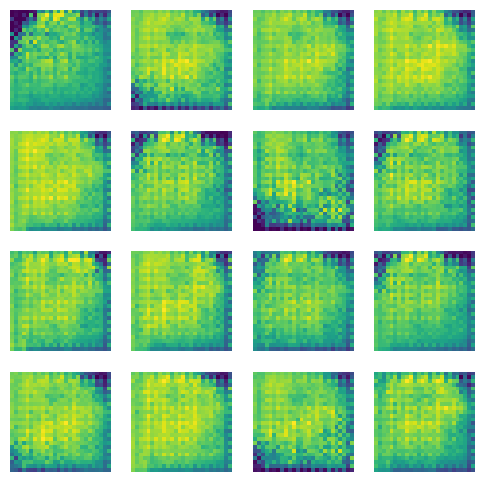

Época 5/10
Pérdida del discriminador: 0.011427333578467369, Pérdida del generador: 5.744457244873047
Pérdida del discriminador: 0.010509774088859558, Pérdida del generador: 5.741701126098633
Pérdida del discriminador: 0.004754828289151192, Pérdida del generador: 5.736785888671875
Pérdida del discriminador: 0.004791039973497391, Pérdida del generador: 5.735002040863037
Pérdida del discriminador: 0.00431335112079978, Pérdida del generador: 5.730301856994629
Pérdida del discriminador: 0.007328787352889776, Pérdida del generador: 5.739950180053711
Pérdida del discriminador: 0.005191114731132984, Pérdida del generador: 5.743129253387451
Pérdida del discriminador: 0.0035552713088691235, Pérdida del generador: 5.7379069328308105
Pérdida del discriminador: 0.0052092005498707294, Pérdida del generador: 5.747122287750244
Pérdida del discriminador: 0.004318334627896547, Pérdida del generador: 5.7536516189575195
Pérdida del discriminador: 0.003879737574607134, Pérdida del generador: 5.757719993591

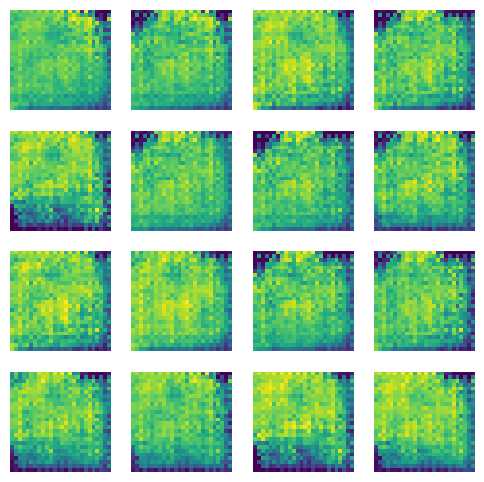

Época 7/10
Pérdida del discriminador: 0.0012444895692169666, Pérdida del generador: 6.768405437469482
Pérdida del discriminador: 0.0034230933524668217, Pérdida del generador: 6.768420219421387
Pérdida del discriminador: 0.018345532938838005, Pérdida del generador: 6.754098892211914
Pérdida del discriminador: 0.0014241536846384406, Pérdida del generador: 6.739004135131836
Pérdida del discriminador: 0.0012562093324959278, Pérdida del generador: 6.730829238891602
Pérdida del discriminador: 0.0013135337503626943, Pérdida del generador: 6.720268249511719
Pérdida del discriminador: 0.01655551791191101, Pérdida del generador: 6.712120056152344
Pérdida del discriminador: 0.001350236707367003, Pérdida del generador: 6.68698263168335
Pérdida del discriminador: 0.0023747580125927925, Pérdida del generador: 6.678343772888184
Pérdida del discriminador: 0.0013155093183740973, Pérdida del generador: 6.660492897033691
Pérdida del discriminador: 0.0025076777674257755, Pérdida del generador: 6.657425403

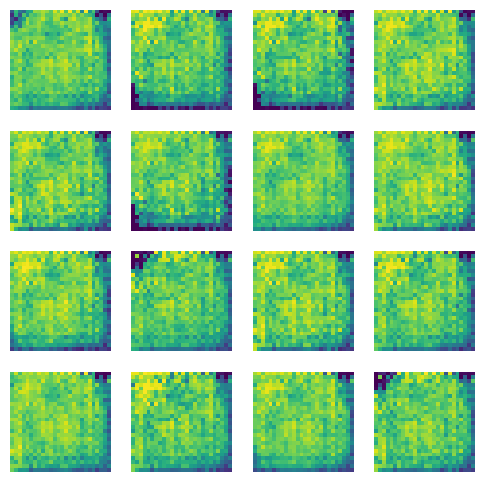

Época 9/10
Pérdida del discriminador: 0.00861925259232521, Pérdida del generador: 7.465956211090088
Pérdida del discriminador: 0.0005949339829385281, Pérdida del generador: 7.457481861114502
Pérdida del discriminador: 0.000765928765758872, Pérdida del generador: 7.44980525970459
Pérdida del discriminador: 0.0007055002497509122, Pérdida del generador: 7.442263603210449
Pérdida del discriminador: 0.000620625214651227, Pérdida del generador: 7.4383745193481445
Pérdida del discriminador: 0.0007570371963083744, Pérdida del generador: 7.437226295471191
Pérdida del discriminador: 0.011731361038982868, Pérdida del generador: 7.427783966064453
Pérdida del discriminador: 0.0006357525126077235, Pérdida del generador: 7.415102005004883
Pérdida del discriminador: 0.0006365971639752388, Pérdida del generador: 7.410858154296875
Pérdida del discriminador: 0.0007539765210822225, Pérdida del generador: 7.4129791259765625
Pérdida del discriminador: 0.0012643459485843778, Pérdida del generador: 7.40326881

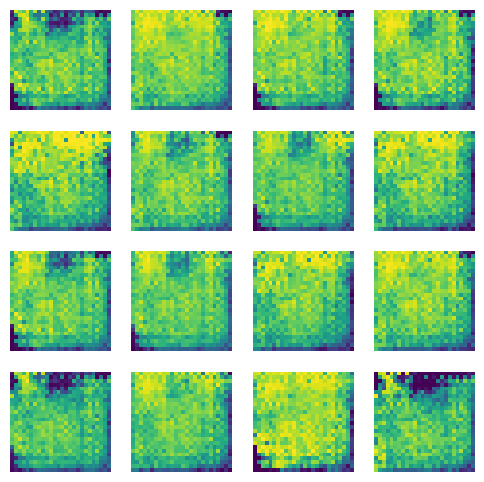

In [ ]:
# Entrenamiento de la GAN
for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")

    for real_images in train_dataset:
        # Obtiene el tamaño del lote actual
        current_batch_size = real_images.shape[0]

        # Genera ruido aleatorio para crear imágenes falsas
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Crea imágenes falsas con el generador
        generated_images = generator(noise, training=True)

        # Etiquetas realies y falsas
        real_labels = tf.ones((current_batch_size, 1)) # Imágenes reales (etiqueta = 1)
        fake_labels = tf.zeros((current_batch_size, 1)) # Imágenes generadas (etiqueta = 0)

        # Entrena el discriminador
        with tf.GradientTape() as disc_tape: # Crea un contexto de gradiente para calcular la pérdida del discriminador.
            # Obtiene las predicciones del discriminador para las imágenes reales.
            real_output = discriminator(real_images, training=True)
            # Obtiene las predicciones del discriminador para las imágenes falsas/generadas.
            fake_output = discriminator(generated_images, training=True)
            # Calcula la pérdida del discriminador para las imágenes reales.
            disc_loss_real = cross_entropy(real_labels, real_output)
            # Calcula la pérdida del discriminador para las imágenes generadas (fake).
            disc_loss_fake = cross_entropy(fake_labels, fake_output)
            # Suma ambas pérdidas para obtener la pérdida todal del discriminador.
            disc_loss = disc_loss_real + disc_loss_fake

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del discriminador
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del discriminador.
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Genera ruido nuevamente para entrenar el generador
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Entrena el generador
        with tf.GradientTape() as gen_tape: # Crea un contexto de gradiente para calcular la pérdida del generador.
            # Crea imágenes falsas con el generador
            generated_images = generator(noise, training=True)
            # Evalúa las imágenes generadas con el discriminador (sin actualizar los pesos).
            fake_output = discriminator(generated_images, training=False)
            # Calcula la pérdida del generador intentando "engañar" al discriminador.
            gen_loss = cross_entropy(real_labels, fake_output)

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del generador.
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del generador.
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Muestra la pérdida de cada red neuronal
        print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

    # Guarda la GAN en ficheros
    # Graba en disco los modelos
    generator.save(f"generador_caras_{epoch + 1}ep_1000img.keras")
    discriminator.save(f"discriminador_caras_{epoch + 1}ep_1000img.keras")


    # Muestra el progreso cada 2 épocas
    if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
        # Genera y muestra imágenes de ejemplo
        noise = tf.random.normal([16, LATENT_DIM])
        generated_images = generator(noise, training=False)
        generated_images = (generated_images + 1) / 2 # Reescala de [-1, 1] a [0, 1]

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for img, ax in zip(generated_images, axes.flatten()):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

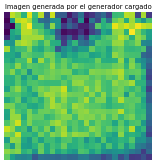

In [ ]:
# Prueba el generador cargado

# Prueba el generador cargado
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Muestra la imagen generada por el generador cargado
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2)  # Reescala la imagen al rango [0, 1]
plt.axis('off')
plt.title("Imagen generada por el generador cargado")
plt.show()